# Visualize attention

In [ ]:
from torch.utils.data.dataloader import DataLoader
from sentiment_classification.reviewsDataset import reviewsDataset
from gpt_utils import dynamic_padding
import tiktoken
import torch
import torch.nn.functional as F
enc = tiktoken.get_encoding("gpt2")
def encode(s: str):
    return enc.encode(s, allowed_special={"<|endoftext|>"},)

rd = reviewsDataset(split="test",cache_dir="/home/varun/Downloads/aclImdb/")
batch_size = 1
dl = DataLoader(rd,shuffle=True,batch_size=batch_size,collate_fn=dynamic_padding)


In [ ]:
from gpt import GPT
from gpt_config import GPTConfig
from bertviz import model_view,head_view

# model_config = GPTConfig(use_lora=True,load_from_checkpoint=True,checkpoint_path="run/dropout_low_lr/finetune_lora.ckpt",debug=True)
model_config = GPTConfig(debug=True,binary_classification_head=False)
model = GPT.from_pretrained(config=model_config,model_type="gpt2-xl")
# ckpt = torch.load(model_config.checkpoint_path)
# model.load_state_dict(ckpt["model"])
model.eval()
# device = "mps"
print("Loaded Model")

In [ ]:
torch.manual_seed(1339)
batch = next(iter(dl))
logits, _,att_out = model(batch["input_ids"],batch["attention_masks"])    
predictions = F.sigmoid(logits)
tokens = []

for input_id in batch["input_ids"][0]:
    tokens.append(f"{enc.decode([input_id.item()])}")

model_view(attention=att_out, tokens=tokens,include_layers=[11]) 

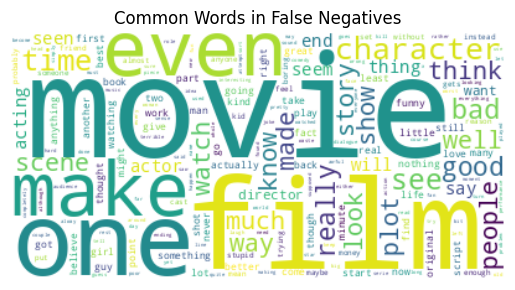

In [11]:
from wordcloud import WordCloud
import pandas
from matplotlib import pyplot as plt
import re
threshold = 0.5
df = pandas.read_csv("zero_shot_128_xl.txt")
fps = df[(df["label"] <= threshold)]["filename"]
fp_text = []
for fname in fps:
    txt = open(fname).read()
    txt = re.sub(r"<.*?>","",txt)
    fp_text.append(txt)

text_false_neg = " ".join(review for review in fp_text)
wordcloud = WordCloud(background_color="white").generate(text_false_neg)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Common Words in False Negatives")
plt.show()